In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

X_train shape: torch.Size([4, 1, 4, 4])
y_train shape: torch.Size([4, 1])


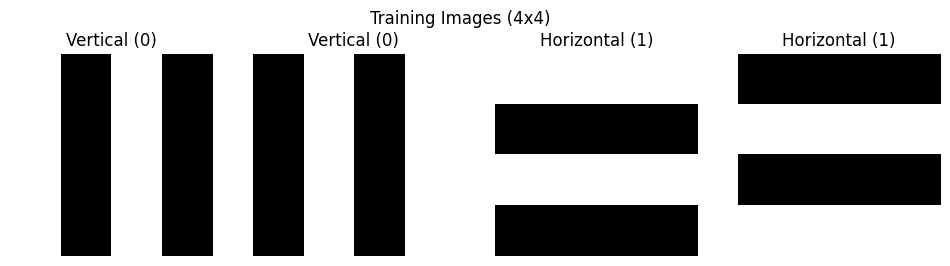

In [2]:
# Simple 4x4 images
# Class 0: Vertical line pattern
# Class 1: Horizontal line pattern

# Image format: (batch, channels, height, width)
X_train = torch.tensor([
    # Vertical lines (Class 0)
    [[[1, 0, 1, 0],
      [1, 0, 1, 0],
      [1, 0, 1, 0],
      [1, 0, 1, 0]]],
    
    [[[0, 1, 0, 1],
      [0, 1, 0, 1],
      [0, 1, 0, 1],
      [0, 1, 0, 1]]],
    
    # Horizontal lines (Class 1)
    [[[1, 1, 1, 1],
      [0, 0, 0, 0],
      [1, 1, 1, 1],
      [0, 0, 0, 0]]],
    
    [[[0, 0, 0, 0],
      [1, 1, 1, 1],
      [0, 0, 0, 0],
      [1, 1, 1, 1]]],
], dtype=torch.float32)

y_train = torch.tensor([[0], [0], [1], [1]], dtype=torch.float32)

print(f"X_train shape: {X_train.shape}")  # (batch, channels, H, W)
print(f"y_train shape: {y_train.shape}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Vertical (0)', 'Vertical (0)', 'Horizontal (1)', 'Horizontal (1)']
for i, ax in enumerate(axes):
    ax.imshow(X_train[i, 0].numpy(), cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.suptitle('Training Images (4x4)')
plt.show()

In [3]:
def conv2d(input_img, kernel, stride=1, padding=0):
    """
    2D Convolution operation.
    
    Args:
        input_img: Input image (H, W)
        kernel: Convolution kernel (kH, kW)
        stride: Step size
        padding: Zero padding
    
    Returns:
        output: Convolved output
    """
    # Add padding
    if padding > 0:
        input_img = torch.nn.functional.pad(input_img, (padding, padding, padding, padding))
    
    H, W = input_img.shape
    kH, kW = kernel.shape
    
    # Output dimensions
    out_H = (H - kH) // stride + 1
    out_W = (W - kW) // stride + 1
    
    output = torch.zeros(out_H, out_W)
    
    # Slide kernel over input
    for i in range(out_H):
        for j in range(out_W):
            # Extract region
            region = input_img[i*stride:i*stride+kH, j*stride:j*stride+kW]
            # Compute dot product (element-wise multiply and sum)
            output[i, j] = torch.sum(region * kernel)
    
    return output

# Test convolution with a simple example
test_input = torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=torch.float32)

test_kernel = torch.tensor([
    [1, 0],
    [0, 1]
], dtype=torch.float32)

result = conv2d(test_input, test_kernel)

print("Input (3x3):")
print(test_input)
print("\nKernel (2x2):")
print(test_kernel)
print("\nOutput (2x2):")
print(result)
print("\nExplanation: output[0,0] = 1*1 + 2*0 + 4*0 + 5*1 = 6")

Input (3x3):
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Kernel (2x2):
tensor([[1., 0.],
        [0., 1.]])

Output (2x2):
tensor([[ 6.,  8.],
        [12., 14.]])

Explanation: output[0,0] = 1*1 + 2*0 + 4*0 + 5*1 = 6


In [4]:
def conv2d_verbose(input_img, kernel):
    """Convolution with detailed output."""
    H, W = input_img.shape
    kH, kW = kernel.shape
    out_H = H - kH + 1
    out_W = W - kW + 1
    
    print(f"Input size: {H}x{W}")
    print(f"Kernel size: {kH}x{kW}")
    print(f"Output size: {out_H}x{out_W}")
    print("\nSliding kernel over input:")
    print("="*50)
    
    output = torch.zeros(out_H, out_W)
    
    for i in range(out_H):
        for j in range(out_W):
            region = input_img[i:i+kH, j:j+kW]
            value = torch.sum(region * kernel)
            output[i, j] = value
            
            print(f"\nPosition ({i},{j}):")
            print(f"Region:\n{region}")
            print(f"Element-wise multiply with kernel:\n{region * kernel}")
            print(f"Sum = {value.item():.1f}")
    
    return output

# Visualize on first training image with a vertical edge detector
edge_kernel = torch.tensor([
    [-1, 1],
    [-1, 1]
], dtype=torch.float32)

print("Vertical Edge Detection Kernel:")
print(edge_kernel)
print("\nApplying to a 3x3 portion of image:")
small_input = X_train[0, 0, :3, :3]  # First 3x3 of first image
_ = conv2d_verbose(small_input, edge_kernel)

Vertical Edge Detection Kernel:
tensor([[-1.,  1.],
        [-1.,  1.]])

Applying to a 3x3 portion of image:
Input size: 3x3
Kernel size: 2x2
Output size: 2x2

Sliding kernel over input:

Position (0,0):
Region:
tensor([[1., 0.],
        [1., 0.]])
Element-wise multiply with kernel:
tensor([[-1.,  0.],
        [-1.,  0.]])
Sum = -2.0

Position (0,1):
Region:
tensor([[0., 1.],
        [0., 1.]])
Element-wise multiply with kernel:
tensor([[-0., 1.],
        [-0., 1.]])
Sum = 2.0

Position (1,0):
Region:
tensor([[1., 0.],
        [1., 0.]])
Element-wise multiply with kernel:
tensor([[-1.,  0.],
        [-1.,  0.]])
Sum = -2.0

Position (1,1):
Region:
tensor([[0., 1.],
        [0., 1.]])
Element-wise multiply with kernel:
tensor([[-0., 1.],
        [-0., 1.]])
Sum = 2.0


In [5]:
def relu(x):
    """ReLU activation: max(0, x)"""
    return torch.maximum(x, torch.tensor(0.0))

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    return (x > 0).float()

# Test
test_x = torch.tensor([-2, -1, 0, 1, 2], dtype=torch.float32)
print(f"Input: {test_x.tolist()}")
print(f"ReLU: {relu(test_x).tolist()}")

Input: [-2.0, -1.0, 0.0, 1.0, 2.0]
ReLU: [0.0, 0.0, 0.0, 1.0, 2.0]


In [6]:
def max_pool2d(input_img, pool_size=2, stride=2):
    """
    2D Max Pooling operation.
    
    Args:
        input_img: Input (H, W)
        pool_size: Size of pooling window
        stride: Step size
    
    Returns:
        output: Pooled output
        max_indices: Indices of max values (for backprop)
    """
    H, W = input_img.shape
    out_H = (H - pool_size) // stride + 1
    out_W = (W - pool_size) // stride + 1
    
    output = torch.zeros(out_H, out_W)
    max_indices = []
    
    for i in range(out_H):
        for j in range(out_W):
            region = input_img[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            max_val = torch.max(region)
            output[i, j] = max_val
            
            # Store index of max for backprop
            max_idx = torch.argmax(region)
            max_indices.append((i*stride + max_idx // pool_size, j*stride + max_idx % pool_size))
    
    return output, max_indices

# Test max pooling
test_pool_input = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
], dtype=torch.float32)

pool_output, pool_indices = max_pool2d(test_pool_input, pool_size=2, stride=2)

print("Input (4x4):")
print(test_pool_input)
print("\nMax Pool Output (2x2):")
print(pool_output)
print("\nExplanation: Each 2x2 region → max value")
print("  Region [0:2, 0:2] = [[1,2],[5,6]] → max = 6")

Input (4x4):
tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

Max Pool Output (2x2):
tensor([[ 6.,  8.],
        [14., 16.]])

Explanation: Each 2x2 region → max value
  Region [0:2, 0:2] = [[1,2],[5,6]] → max = 6


In [7]:
# CNN Parameters
in_channels = 1
out_channels = 2  # 2 filters
kernel_size = 2
pool_size = 2
input_h, input_w = 4, 4

# Calculate dimensions after conv and pool
# After conv: (4-2+1) = 3x3
# After pool: (3-2)/2 + 1 = 1 (but we'll use stride 1 pooling to get 2x2)
# Let's use: after conv 3x3, after pool (with stride 1, size 2) = 2x2

conv_out_h = input_h - kernel_size + 1  # 3
conv_out_w = input_w - kernel_size + 1  # 3
pool_out_h = conv_out_h - pool_size + 1  # 2 (stride 1)
pool_out_w = conv_out_w - pool_size + 1  # 2

flatten_size = out_channels * pool_out_h * pool_out_w  # 2 * 2 * 2 = 8

print(f"Input: {input_h}x{input_w}")
print(f"After Conv ({kernel_size}x{kernel_size}, {out_channels} filters): {conv_out_h}x{conv_out_w}x{out_channels}")
print(f"After Pool ({pool_size}x{pool_size}): {pool_out_h}x{pool_out_w}x{out_channels}")
print(f"Flattened: {flatten_size}")

Input: 4x4
After Conv (2x2, 2 filters): 3x3x2
After Pool (2x2): 2x2x2
Flattened: 8


In [8]:
def init_cnn_weights():
    """
    Initialize CNN weights.
    """
    # Convolutional filters: (out_channels, in_channels, kH, kW)
    # We have 2 filters, each 2x2
    conv_filters = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.5
    conv_bias = torch.zeros(out_channels)
    
    # Fully connected layer
    fc_weights = torch.randn(flatten_size, 1) * 0.5
    fc_bias = torch.zeros(1)
    
    return {
        'conv_filters': conv_filters,
        'conv_bias': conv_bias,
        'fc_weights': fc_weights,
        'fc_bias': fc_bias
    }

weights = init_cnn_weights()

print("CNN Weights:")
print(f"  Conv filters: {weights['conv_filters'].shape}")
print(f"  Conv bias: {weights['conv_bias'].shape}")
print(f"  FC weights: {weights['fc_weights'].shape}")
print(f"  FC bias: {weights['fc_bias'].shape}")

CNN Weights:
  Conv filters: torch.Size([2, 1, 2, 2])
  Conv bias: torch.Size([2])
  FC weights: torch.Size([8, 1])
  FC bias: torch.Size([1])


In [9]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def cnn_forward(X, weights):
    """
    CNN forward pass for a single image.
    
    Args:
        X: Input image (channels, H, W)
        weights: Dictionary of weights
    
    Returns:
        y_pred: Prediction
        cache: Values for backprop
    """
    conv_filters = weights['conv_filters']
    conv_bias = weights['conv_bias']
    fc_weights = weights['fc_weights']
    fc_bias = weights['fc_bias']
    
    # === Convolution Layer ===
    # Apply each filter
    conv_outputs = []
    for f in range(out_channels):
        # Convolve input with filter f
        conv_out = conv2d(X[0], conv_filters[f, 0]) + conv_bias[f]
        conv_outputs.append(conv_out)
    
    conv_out = torch.stack(conv_outputs)  # (out_channels, H', W')
    
    # === ReLU Activation ===
    relu_out = relu(conv_out)
    
    # === Max Pooling ===
    pool_outputs = []
    pool_indices_list = []
    for f in range(out_channels):
        pool_out, pool_idx = max_pool2d(relu_out[f], pool_size=2, stride=1)
        pool_outputs.append(pool_out)
        pool_indices_list.append(pool_idx)
    
    pool_out = torch.stack(pool_outputs)  # (out_channels, H'', W'')
    
    # === Flatten ===
    flattened = pool_out.flatten().unsqueeze(0)  # (1, flatten_size)
    
    # === Fully Connected Layer ===
    fc_out = torch.matmul(flattened, fc_weights) + fc_bias
    
    # === Sigmoid Output ===
    y_pred = sigmoid(fc_out)
    
    # Store cache for backprop
    cache = {
        'input': X,
        'conv_out': conv_out,
        'relu_out': relu_out,
        'pool_out': pool_out,
        'pool_indices': pool_indices_list,
        'flattened': flattened,
        'fc_out': fc_out
    }
    
    return y_pred, cache

# Test forward pass
y_pred, cache = cnn_forward(X_train[0], weights)
print(f"Input shape: {X_train[0].shape}")
print(f"Conv output shape: {cache['conv_out'].shape}")
print(f"Pool output shape: {cache['pool_out'].shape}")
print(f"Flattened shape: {cache['flattened'].shape}")
print(f"Prediction: {y_pred.item():.4f}")

Input shape: torch.Size([1, 4, 4])
Conv output shape: torch.Size([2, 3, 3])
Pool output shape: torch.Size([2, 2, 2])
Flattened shape: torch.Size([1, 8])
Prediction: 0.5326


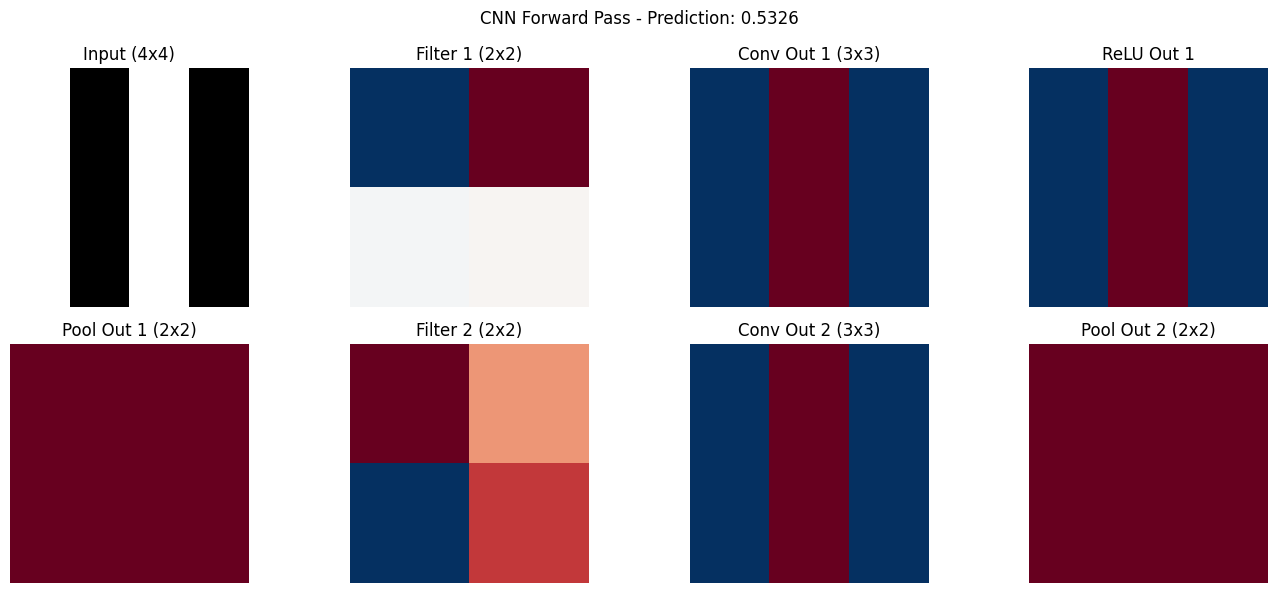

In [10]:
def visualize_cnn_forward(X, weights):
    """Visualize each layer of CNN."""
    y_pred, cache = cnn_forward(X, weights)
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    
    # Input
    axes[0, 0].imshow(X[0].numpy(), cmap='gray')
    axes[0, 0].set_title('Input (4x4)')
    axes[0, 0].axis('off')
    
    # Filter 1
    axes[0, 1].imshow(weights['conv_filters'][0, 0].numpy(), cmap='RdBu')
    axes[0, 1].set_title('Filter 1 (2x2)')
    axes[0, 1].axis('off')
    
    # Conv output 1
    axes[0, 2].imshow(cache['conv_out'][0].numpy(), cmap='RdBu')
    axes[0, 2].set_title('Conv Out 1 (3x3)')
    axes[0, 2].axis('off')
    
    # ReLU output 1
    axes[0, 3].imshow(cache['relu_out'][0].numpy(), cmap='RdBu')
    axes[0, 3].set_title('ReLU Out 1')
    axes[0, 3].axis('off')
    
    # Pool output 1
    axes[1, 0].imshow(cache['pool_out'][0].numpy(), cmap='RdBu')
    axes[1, 0].set_title('Pool Out 1 (2x2)')
    axes[1, 0].axis('off')
    
    # Filter 2
    axes[1, 1].imshow(weights['conv_filters'][1, 0].numpy(), cmap='RdBu')
    axes[1, 1].set_title('Filter 2 (2x2)')
    axes[1, 1].axis('off')
    
    # Conv output 2
    axes[1, 2].imshow(cache['conv_out'][1].numpy(), cmap='RdBu')
    axes[1, 2].set_title('Conv Out 2 (3x3)')
    axes[1, 2].axis('off')
    
    # Pool output 2
    axes[1, 3].imshow(cache['pool_out'][1].numpy(), cmap='RdBu')
    axes[1, 3].set_title('Pool Out 2 (2x2)')
    axes[1, 3].axis('off')
    
    plt.suptitle(f'CNN Forward Pass - Prediction: {y_pred.item():.4f}')
    plt.tight_layout()
    plt.show()

visualize_cnn_forward(X_train[0], weights)

In [11]:
def binary_cross_entropy(y_true, y_pred):
    """Binary Cross-Entropy Loss"""
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

print("BCE Loss function defined!")

BCE Loss function defined!


In [12]:
def conv2d_backward(d_out, input_img, kernel):
    """
    Backward pass for convolution.
    
    Returns:
        d_kernel: Gradient w.r.t kernel
        d_input: Gradient w.r.t input
    """
    kH, kW = kernel.shape
    out_H, out_W = d_out.shape
    
    d_kernel = torch.zeros_like(kernel)
    d_input = torch.zeros_like(input_img)
    
    # Compute kernel gradient
    for i in range(out_H):
        for j in range(out_W):
            region = input_img[i:i+kH, j:j+kW]
            d_kernel += d_out[i, j] * region
    
    # Compute input gradient (full convolution with flipped kernel)
    padded_d_out = torch.nn.functional.pad(d_out, (kW-1, kW-1, kH-1, kH-1))
    flipped_kernel = torch.flip(kernel, [0, 1])
    
    for i in range(input_img.shape[0]):
        for j in range(input_img.shape[1]):
            region = padded_d_out[i:i+kH, j:j+kW]
            d_input[i, j] = torch.sum(region * flipped_kernel)
    
    return d_kernel, d_input

def cnn_backward(y_true, y_pred, cache, weights):
    """
    CNN backward pass.
    """
    grads = {
        'conv_filters': torch.zeros_like(weights['conv_filters']),
        'conv_bias': torch.zeros_like(weights['conv_bias']),
        'fc_weights': torch.zeros_like(weights['fc_weights']),
        'fc_bias': torch.zeros_like(weights['fc_bias'])
    }
    
    # === Output Layer Gradient ===
    # d_loss/d_sigmoid_input = y_pred - y_true (for BCE with sigmoid)
    d_fc_out = y_pred - y_true
    
    # === FC Layer Gradient ===
    grads['fc_weights'] = torch.matmul(cache['flattened'].T, d_fc_out)
    grads['fc_bias'] = d_fc_out.squeeze()
    
    # Gradient to flattened
    d_flattened = torch.matmul(d_fc_out, weights['fc_weights'].T)
    
    # === Reshape to pool output ===
    d_pool_out = d_flattened.reshape(cache['pool_out'].shape)
    
    # === Max Pool Backward ===
    d_relu_out = torch.zeros_like(cache['relu_out'])
    for f in range(out_channels):
        pool_h, pool_w = cache['pool_out'][f].shape
        for i in range(pool_h):
            for j in range(pool_w):
                # Get original position of max
                idx = i * pool_w + j
                max_i, max_j = cache['pool_indices'][f][idx]
                d_relu_out[f, max_i, max_j] += d_pool_out[f, i, j]
    
    # === ReLU Backward ===
    d_conv_out = d_relu_out * relu_derivative(cache['conv_out'])
    
    # === Conv Backward ===
    for f in range(out_channels):
        d_kernel, _ = conv2d_backward(
            d_conv_out[f], 
            cache['input'][0], 
            weights['conv_filters'][f, 0]
        )
        grads['conv_filters'][f, 0] = d_kernel
        grads['conv_bias'][f] = torch.sum(d_conv_out[f])
    
    return grads

print("CNN backward pass defined!")

CNN backward pass defined!


In [13]:
# Hyperparameters
learning_rate = 0.5
epochs = 200

# Re-initialize weights
torch.manual_seed(42)
weights = init_cnn_weights()

# Store losses
losses = []

print("Training CNN...")
print("="*50)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    # Accumulate gradients
    total_grads = {
        'conv_filters': torch.zeros_like(weights['conv_filters']),
        'conv_bias': torch.zeros_like(weights['conv_bias']),
        'fc_weights': torch.zeros_like(weights['fc_weights']),
        'fc_bias': torch.zeros_like(weights['fc_bias'])
    }
    
    for i in range(len(X_train)):
        # Forward pass
        y_pred, cache = cnn_forward(X_train[i], weights)
        
        # Compute loss
        loss = binary_cross_entropy(y_train[i:i+1], y_pred)
        epoch_loss += loss.item()
        
        # Backward pass
        grads = cnn_backward(y_train[i:i+1], y_pred, cache, weights)
        
        # Accumulate gradients
        for key in total_grads:
            total_grads[key] += grads[key]
    
    # Average gradients
    n_samples = len(X_train)
    for key in total_grads:
        total_grads[key] /= n_samples
    
    # Update weights
    for key in weights:
        weights[key] = weights[key] - learning_rate * total_grads[key]
    
    # Store average loss
    avg_loss = epoch_loss / n_samples
    losses.append(avg_loss)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

Training CNN...
Epoch    0 | Loss: 0.726400
Epoch   20 | Loss: 0.030762
Epoch   40 | Loss: 0.007844
Epoch   60 | Loss: 0.004079
Epoch   80 | Loss: 0.002762
Epoch  100 | Loss: 0.002081
Epoch  120 | Loss: 0.001644
Epoch  140 | Loss: 0.001354
Epoch  160 | Loss: 0.001151
Epoch  180 | Loss: 0.000995

Final Loss: 0.000878


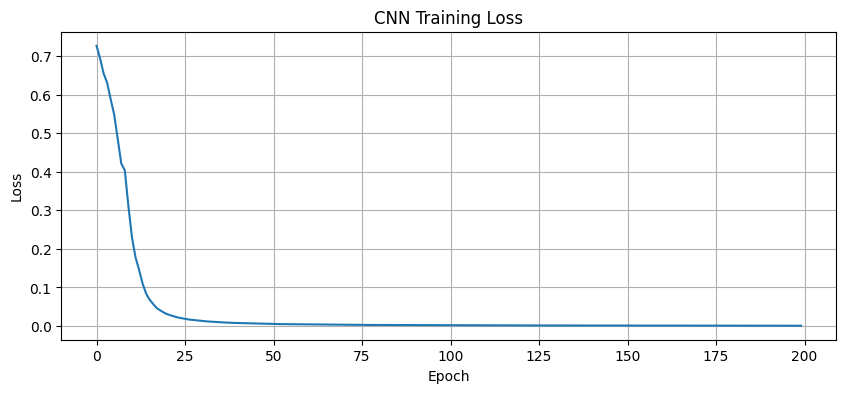

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss')
plt.grid(True)
plt.show()

In [15]:
print("Predictions on Training Data:")
print("="*60)
print(f"{'Image':<10} {'True Label':<12} {'Predicted':<12} {'Rounded':<10}")
print("-"*60)

correct = 0
for i in range(len(X_train)):
    y_pred, _ = cnn_forward(X_train[i], weights)
    true_label = int(y_train[i].item())
    pred_prob = y_pred.item()
    pred_label = 1 if pred_prob > 0.5 else 0
    correct += (pred_label == true_label)
    
    pattern = "Vertical" if true_label == 0 else "Horizontal"
    print(f"{pattern:<10} {true_label:<12} {pred_prob:<12.4f} {pred_label:<10}")

print(f"\nAccuracy: {correct}/{len(X_train)} = {100*correct/len(X_train):.1f}%")
print("\n✓ CNN has learned to classify vertical vs horizontal lines!")

Predictions on Training Data:
Image      True Label   Predicted    Rounded   
------------------------------------------------------------
Vertical   0            0.0009       0         
Vertical   0            0.0009       0         
Horizontal 1            0.9992       1         
Horizontal 1            0.9992       1         

Accuracy: 4/4 = 100.0%

✓ CNN has learned to classify vertical vs horizontal lines!


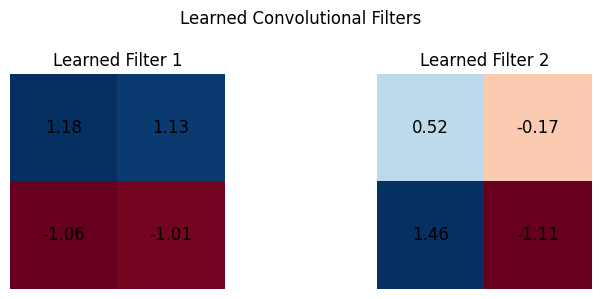

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for i in range(2):
    axes[i].imshow(weights['conv_filters'][i, 0].detach().numpy(), cmap='RdBu')
    axes[i].set_title(f'Learned Filter {i+1}')
    axes[i].axis('off')
    
    # Add values as text
    filt = weights['conv_filters'][i, 0].detach().numpy()
    for y in range(filt.shape[0]):
        for x in range(filt.shape[1]):
            axes[i].text(x, y, f'{filt[y,x]:.2f}', ha='center', va='center', fontsize=12)

plt.suptitle('Learned Convolutional Filters')
plt.tight_layout()
plt.show()